<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Distributed computing with MPI

## Contents


In this notebook, we will learn the basics of parallel computing using the Message Passing Interface (MPI) from Julia. In particular, we will learn:

- How to run parallel MPI code in Julia
- How to use basic collective communication directives
- How to use basic point-to-point communication directives

For further information on how to use MPI from Julia see https://github.com/JuliaParallel/MPI.jl


## What is MPI ?

- MPI stands for the "Message Passing Interface"
- It is a standardized library specification for communication between parallel processes in distributed-memory systems.
- It is the gold-standard for distributed computing in HPC systems since the 90s
- It is huge: the MPI standard has more than 1k pages (see https://www.mpi-forum.org/docs/mpi-4.0/mpi40-report.pdf)
- There are several implementations of this standard (OpenMPI, MPICH, IntelMPI)
- The interface is in C and FORTRAN (C++ was deprecated)
- There are Julia bindings via the package MPI.jl https://github.com/JuliaParallel/MPI.jl

### What is MPI.jl ?

- It is not a Julia implementation of the MPI standard
- It is a wrapper to the C interface of MPI
- You need a C MPI installation in your system


MPI.jl provides a convenient Julia API to access MPI. For instance, this is how you get the id (rank) of the current process.

```julia
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
```

Internally, MPI.jl uses `ccall` which is a mechanism that allows you to call C functions from Julia. In this, example we are calling the C function `MPI_Comm_rank` from the underlying MPI installation.

```julia
comm = MPI.COMM_WORLD    
rank_ref = Ref{Cint}()
ccall((:MPI_Comm_rank, MPI.API.libmpi), Cint, (MPI.API.MPI_Comm, Ptr{Cint}), comm, rank_ref)
rank = Int(rank_ref[])
```



### Installing MPI in Julia

The Jupyter Julia kernel installed by IJulia activates the folder where the notebook is located as the default environment, which causes the main process and the worker processes to not share the same environment. Therefore, we need to set the environment as the global environment.

In [ ]:
] activate

MPI can be installed as any other Julia package using the package manager.

In [ ]:
] add MPI

<div class="alert alert-block alert-info">
<b>Note:</b> The package you have installed it is the Julia interface to MPI, called MPI.jl. Note that it is not a MPI library by itself. It is just a thin wrapper between MPI and Julia. To use this interface, you need an actual MPI library installed in your system such as OpenMPI or MPICH. Julia downloads and installs a MPI library for you, but it is also possible to use a MPI library already available in your system. This is useful, e.g., when running on HPC clusters. See the documentation of MPI.jl for further details. See more information in <a href="https://github.com/JuliaParallel/MPI.jl">https://github.com/JuliaParallel/MPI.jl</a>
</div>

## Minimal MPI program


In Julia:

```julia
using MPI
MPI.Init()
# Your MPI programm here
# ...
MPI.Finalize()
```

In C:

```C
#include <mpi.h>
int main(int argc, char** argv) {
    MPI_Init(NULL, NULL);
    /* Your MPI Programm here */
    MPI_Finalize();
}
```

<div class="alert alert-block alert-info">
<b>Note:</b> Note that the Julia syntax is almost 1-to-1 to the C one. The key difference is that in Julia MPI routines are written as `MPI.X` where in C are written `MPI_X`.
</div>


* It is mandatory to initialize MPI before using MPI procedures.
* In C, all processes must call `MPI_Finalize` before exiting.
* In Julia, either all or none process must call `MPI.Finalize()`.
* Once finalized, MPI cannot be re

### An incorrect MPI program

```julia
using MPI
MPI.Init()
@assert rand(1:10) != 2
MPI.Finalize()
```

In some process `rand(1:10)` might be 2 and the program will stop without reaching `MPI.Finalize()`.

### Solving the issue

Premature finalization of a program is done with `MPI.Abort`.

```julia
using MPI
MPI.Init()
if rand(1:10) != 2
    errorcode = -1
    MPI.Abort(MPI.COMM_WORLD,errorcode)
end
MPI.Finalize()
```

* There is no need to call `MPI.Abort` in all ranks.

### Read the docs

Not sure if an MPI routine needs to be called by all the ranks? Read the documentation, and/or the MPI standard.

In [ ]:
? MPI.Finalize

## Basic information about MPI processes

The following cells give information about MPI processes, such as the rank id, the total number of processes and the name of the host running the code respectively. Before calling this functions one needs to initialize MPI.

In [ ]:
using MPI
MPI.Init()

 Current rank (process) id

In [ ]:
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)

Number of available processes

In [ ]:
nranks = MPI.Comm_size(comm)

Name of the current host

In [ ]:
MPI.Get_processor_name()

Note that this note notebook is not running with different MPI processes (yet). So using MPI will only make sense later when we add more processes.

### Hello-world example

Using these functions we can create the a classic MPI hello world example. This example (or variations thereof) is used in practice to check how MPI ranks are mapped to available processing units in a given computing system.


In [ ]:
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
host = MPI.Get_processor_name()
println("Hello from $host, I am process $rank of $nranks processes!")

### Hello world in C

```C
#include <mpi.h>
#include <stdio.h>
int main(int argc, char** argv) {
    MPI_Init(NULL, NULL);
    int world_size;
    MPI_Comm_size(MPI_COMM_WORLD, &world_size);
    int world_rank;
    MPI_Comm_rank(MPI_COMM_WORLD, &world_rank);
    char processor_name[MPI_MAX_PROCESSOR_NAME];
    int name_len;
    MPI_Get_processor_name(processor_name, &name_len);
    printf("Hello from %s, I am rank %d of %d ranks!\n",
           processor_name, world_rank, world_size);
    MPI_Finalize();
}
```

## Running MPI code

### Creating MPI processes (aka ranks)

- MPI processes are created with the driver program `mpiexec`
- `mpiexec` takes an application and runs it on different ranks
- The application calls MPI directives to communicate between these ranks
- The application can be Julia running your script in particular.


 <div>
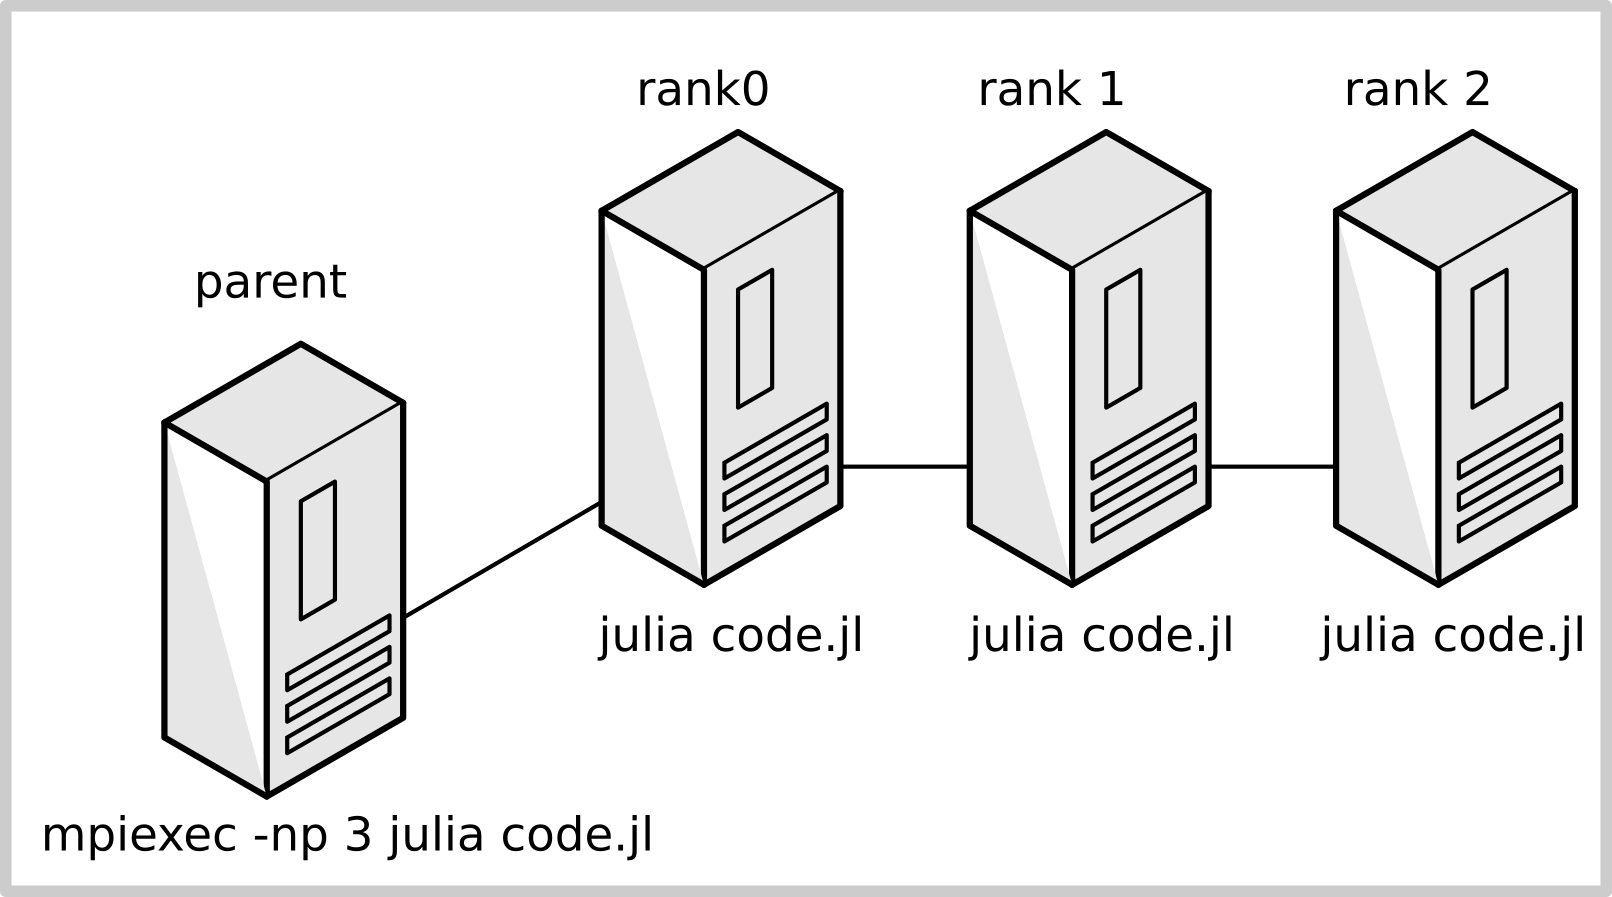
</div>

### Execution model

- MPI programs are typically run with a Single Program Multiple Data (SPMD) model
- But the standard supports Multiple Program Multiple Data (MPMD)

### Hello world

Julia code typically needs to be in a file to run it in with MPI. Let's us write our hello world in a file:

In [ ]:
code = raw"""
using MPI
MPI.Init()
comm = MPI.COMM_WORLD
nranks = MPI.Comm_size(comm)
rank = MPI.Comm_rank(comm)
println("Hello, I am process $rank of $nranks processes!")
MPI.Finalize()
"""
filename = tempname()*".jl"
write(filename,code);

Now, we can run it

In [ ]:
using MPI
run(`$(mpiexec()) -np 4 julia --project=. $filename`);

<div class="alert alert-block alert-info">
<b>Note:</b> Function `mpiexec` provided by `MPI.jl` is a convenient way of accessing the `mpiexec` program that matches the MPI installation used my Julia.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Note that the rank ids start with 0.
</div>

### Another way to launch MPI code

In the Hello world example above we have created an auxiliary file to run the code with MPI. This can be annoying specially if you are working in a jupyter notebook. With this other syntax you can skip creating the auxiliary file. we use `quote` which is part of the [meta-programming capabilities of Julia](https://docs.julialang.org/en/v1/manual/metaprogramming/). 

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    println("Hello, I am process $rank of $nranks processes!")
    MPI.Finalize()
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Data availability

Note that mpiexec creates new processes which are different from the process running this notebook. In particular, these new processes will not see any variables or function definitions in the current notebook. So, the full MPI program needs to be in the source file passed to Julia or the quote block.

In [ ]:
foo() = print("Hi there!")
code = quote
    using MPI
    MPI.Init()
    foo()
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

So, the full MPI program needs to be in the source file passed to Julia or the quote block. In practice, long MPI programms are written as Julia packages using several files, which are then loaded by each MPI process. 

In [ ]:
code = quote
    foo() = print("Hi there!")
    using MPI
    MPI.Init()
    foo()
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Point-to-point communication

MPI  provides point-to-point communication directives for arbitrary communication between processes. Point-to-point communications are two-sided: there is a sender and a receiver. Here, we will discuss these basic directives:

- `MPI_Send`, and `MPI_Recv!` (*blocking directives*)
- `MPI_Isend`, and `MPI_Irecv!` (*non-blocking directives, aka incomplete directives*)
- `MPI_Bsend`, `MPI_Ssend`, and `MPI_Rsend` (*advanced communication modes*)

<div>
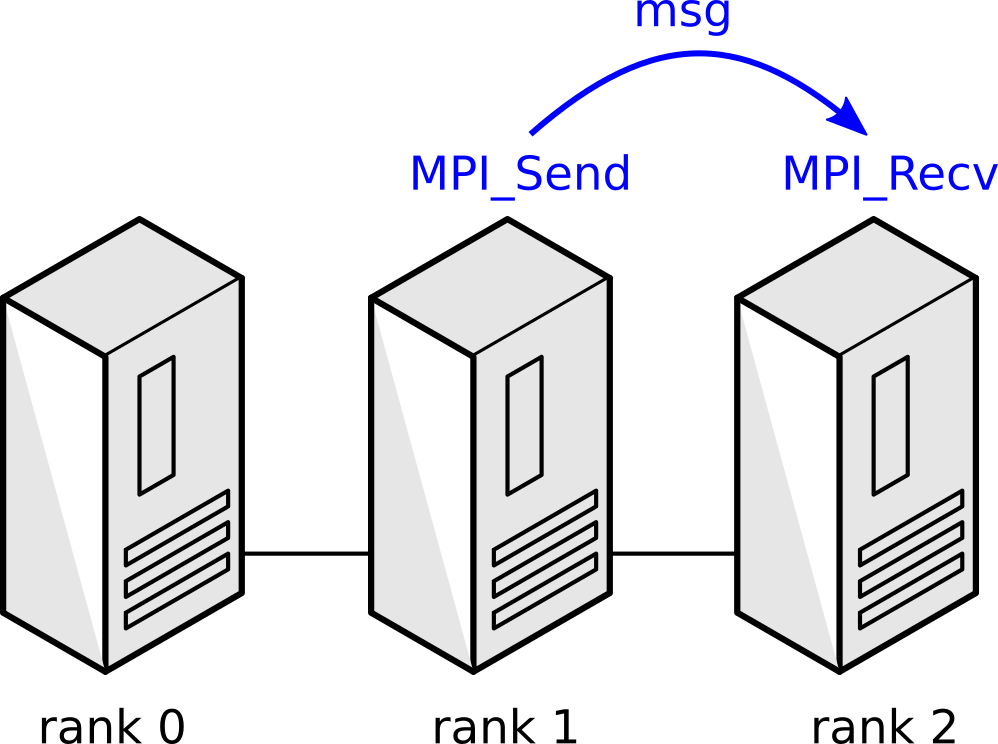
</div>

## Blocking send and receive

In Julia:

```julia
MPI.Send(sndbuf, comm; dest, tag)
_, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
```
In C:
```C
int MPI_Send(const void *sndbuf, int count, MPI_Datatype datatype, int dest,
    int tag, MPI_Comm comm)
int MPI_Recv(void *rcvbuf, int count, MPI_Datatype datatype,
    int source, int tag, MPI_Comm comm, MPI_Status *status)
```

Key arguments:

* `sndbuf` data to send.
* `rcvbuf` space to store the received data.
* `source` rank of the sender.
* `dest` rank of the receiver.
* `tag`. Might be used to distinguish between different kinds of messages (i.e., the "subject" in an email)


### Example

Send 5 integers from rank 2 to rank 3.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Any source, any tag

We can use

* `source = MPI.ANY_SOURCE`
* `tag = MPI.ANY_TAG`

If we want to receive messages from any source and/or with any tag.


<div class="alert alert-block alert-info">
<b>Note:</b> These can only be used by the receiver, not the sender. Moreover there is no option to send to any destination.
</div>


### Example

Send 5 integers from rank 2 to rank 3.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Who was the sender? Which was the tag?

When using `MPI.ANY_SOURCE` and `MPI.ANY_TAG` it might be still useful to know which was the sender and which tag was used. This information is given by a `MPI.Status` object.


```julia
_, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
status.source # Gives the source
status.tag # Gives the tag
```




In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        _, status = MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
        @show status.source
        @show status.tag
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Which is the incoming message size?

Note that we need to provide a receive buffer with the right size, but it general we might do not know which is the size of the incoming message. This can be solved using an `MPI_Probe`. It works similar to `MPI_Recv`, but instead of receiving the message only receives information about the message (source, tag, and also message size).

```julia
status = MPI.Probe(comm,MPI.Status; source, tag)
count = MPI.Get_count(status, T)
```
```C
int MPI_Probe(int source, int tag, MPI_Comm comm, MPI_Status *status)
int MPI_Get_count(const MPI_Status *status, MPI_Datatype datatype, int *count)
```

We can get the message size from the status object using function `MPI_Get_count`. We can also get the source and tag from the status object as shown before.

### Example

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
    end
    if rank == 3
        source = MPI.ANY_SOURCE
        tag = MPI.ANY_TAG
        status = MPI.Probe(comm,MPI.Status; source, tag)
        count = MPI.Get_count(status,Int)
        println("I am about to receive $count integers.")
        rcvbuf = zeros(Int,count)        
        MPI.Recv!(rcvbuf, comm, MPI.Status; source, tag)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Blocking semantics

Functions `MPI_Send` and `MPI_Recv` are *blocking*.

This means:

- It is safe to re-write the send buffer once `MPI_Send` returns.
- The received message is guaranteed to be fully available in the receive buffer once `MPI_Recv` returns.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        sndbuf .= 0 # This is fine. Send has returned.
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        # recvbuf will have the incomming message fore sure. Recv! has returned.
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

However:
- We cannot assume synchronization between sender and receiver. I.e., *blocking* is not the same as *synchronous*. We cannot assume that a receive has been posted once `MPI_Send` returns as the underlying implementation might copy the send message into an internal buffer and return before any matching `MPI_Recv` started.

- A blocking send is not *synchronous*, but we cannot assume that it is *asynchronous*.  The underlying implementation might not use any auxiliary buffer and wait for a matching receive. Assuming buffering is erroneous and can lead to dead locks.

### Incorrect program

The following program will or will not work depending whether the underlying implementation uses buffering. On my laptop, it works with `n=1`, but leads to a dead lock when `n=10000`. The MPI implementation decided to buffer or not depending on the message size.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 1
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=3, tag=0)
    end
    if rank == 3
        MPI.Send(sndbuf, comm; dest=2, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Correct program

We can fix the program by smartly ordering the sends and the receives. This should work for any value of `n` as long as we have enough memory in the system.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 10000
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        MPI.Send(sndbuf, comm; dest=3, tag=0)
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=3, tag=0)
    end
    if rank == 3
        MPI.Recv!(rcvbuf, comm, MPI.Status; source=2, tag=0)
        MPI.Send(sndbuf, comm; dest=2, tag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

Another solution is to use `MPI_Sendrecv`.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    n = 10000
    sndbuf = fill(rank,n)
    rcvbuf = zeros(Int,n)
    if rank == 2
        MPI.Sendrecv!(sndbuf,rcvbuf, comm;dest=3,source=3,sendtag=0,recvtag=0)
    end
    if rank == 3
        MPI.Sendrecv!(sndbuf,rcvbuf, comm;dest=2,source=2,sendtag=0,recvtag=0)
    end
    @show (rcvbuf[1],rank)
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

## Communication modes

In all cases, it is safe to reuse the send buffer once the corresponding send returns. I.e., all the following sends are *complete* MPI operations. However, there are some important differences.

### Standard

* `MPI_Send` 
* Programmer cannot make any assumptions whether the message is buffered or synchronous.
* This is up to the system.

### Buffered

* `MPI_Bsend`
* Programmer provides additional internal buffer space with function `MPI_Buffer_attach`.
* `MPI_Bsend` completes when message is copied into a local buffer.
* Erroneous if buffer space is insufficient.

### Synchronous

* `MPI_Ssend`
* The send will only return if a matching receive was posted.
* No buffering → easy to get deadlocks
* It can be started whether or not a matching receive was posted.

### Ready

* `MPI_Rsend`
* It may be started only if the matching receive is already posted.
* Erroneous if there is no matching receive yet.
* Otherwise, same as an `MPI_Ssend`.


 All these send types are matched with a `MPI_Recv`. I.e., there is no `MPI_Brecv`, `MPI_Srecv`, `MPI_Rrecv`. For further information about the communication modes, refer to [this section](https://www.mpi-forum.org/docs/mpi-2.2/mpi22-report/node53.htm) of the MPI standard.
 
 
<div class="alert alert-block alert-info">
<b>Note:</b>  `MPI_Bsend`, `MPI_Ssend`, and `MPI_Rsend` are not exposed in the Julia bindings via a high-level interface like for `MPI.Send`, but they can be accessed using the low-level bindings in the submodule `MPI.API` (not shown in this notebook).
</div>
 
 


## Non-blocking send and receive

- They return immediately.
- The send and receive is not completed when the function returns. I.e. they are *incomplete* operations.
- `MPI_Wait` used to wait for completion of the send and/or receive.

- Used to overlap communication and computation ("latency-hiding").


```julia
request = MPI.Isend(sndbuf, comm; dest, tag)
request = MPI.Irecv!(rcvbuf, comm; source, tag)
```

```C
int MPI_Isend(const void *sndbuf, int count, MPI_Datatype datatype, int dest,
    int tag, MPI_Comm comm, MPI_Request *request)
int MPI_Irecv(void *rcvbuf, int count, MPI_Datatype datatype,
    int source, int tag, MPI_Comm comm, MPI_Request *request)

```

### Example

Send 5 integers from rank 2 to rank 3. Both ranks do some work while messages are being communicated.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        work()
        MPI.Wait(request)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        work()
        MPI.Wait(request)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Incorrect program

This program in incorrect both on the send and the receive side.

- One needs to wait for completion before reseting the send buffer
- One needs to wait for completion before using the receive buffer



In [ ]:
code = quote
    using MPI
    MPI.Init()
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        sndbuf .= 10 # We cannot set the sndbuf before MPI.Wait.
        MPI.Wait(request)
    end
    if rank == 3
        rcvbuf = zeros(Int,5)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        @show rcvbuf  # Not guaranteed to have the correct value.
        MPI.Wait(request)
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

### Which is the incoming message size?

If we use `MPI_Probe` we miss the opportunity to do local work before a send is started.

In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sleep(5) # Sleep 5 seconds
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        MPI.Wait(request)
    end
    if rank == 3
        # We are going to wait here for about 5 seconds
        # Missing the opportunity to do some useful work
        status = MPI.Probe(comm,MPI.Status; source=2, tag=0)
        count = MPI.Get_count(status,Int)
        rcvbuf = zeros(Int,count)
        request = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
        work()
        MPI.Wait(request)
        @show rcvbuf
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

We can fix this using an `MPI_Iprobe`. It allows us to check for incoming messages without blocking.

```julia
ismsg, status = MPI.Iprobe(comm, MPI.Status; source, tag)
```
```C
int MPI_Iprobe(int source, int tag, MPI_Comm comm, int *flag,
    MPI_Status *status)


In [ ]:
code = quote
    using MPI
    MPI.Init()
    work() = sum(rand(1000))
    comm = MPI.COMM_WORLD
    rank = MPI.Comm_rank(comm)
    if rank == 2
        sleep(5) # Sleep 5 seconds
        sndbuf = [1,2,3,5,8]
        request = MPI.Isend(sndbuf, comm; dest=3, tag=0)
        MPI.Wait(request)
    end
    if rank == 3
        while true
            ismsg, status = MPI.Iprobe(comm, MPI.Status; source=2, tag=0)
            if ismsg
                count = MPI.Get_count(status,Int)
                rcvbuf = zeros(Int,count)
                reqrcv = MPI.Irecv!(rcvbuf, comm; source=2, tag=0)
                work()
                MPI.Wait(reqrcv)
                @show rcvbuf
                break
            end
            work() # Do work while waiting for an incoming message.
        end
    end
end
run(`$(mpiexec()) -np 4 julia --project=. -e $code`);

In [ ]:
? MPI.Iprobe

## MPI Communicators

In MPI, a **communicator** represents a group of processes that can communicate with each other. `MPI_COMM_WORLD` (`MPI.COMM_WORLD` from Julia) is a built-in communicator that represents all processes available in the MPI program.  Custom communicators can also be created to group processes based on specific requirements or logical divisions.  The **rank** of a processor is a unique (integer) identifier assigned to each process within a communicator. It allows processes to distinguish and address each other in communication operations.

### Duplicating a communicator

It is a good practice to not using the built-in communicators directly, and use a copy instead with `MPI.Comm_dup`. Different libraries using the same communicator can lead to unexpected interferences.

## Collective communication

MPI provides collective communication functions for communication involving multiple processes. Some usual collective directives are:

- `MPI.Gather`: Gathers data from all processes to a single process.
- `MPI.Scatter`: Distributes data from one process to all processes.
- `MPI.Bcast`: Broadcasts data from one process to all processes.
- `MPI.Barrier`: Synchronizes all processes.

See more collective directives available from Julia here: https://juliaparallel.org/MPI.jl/stable/reference/collective/


### Gather

Each rank sends a message to the root rank (the root rank also sends a message to itself). The root rank receives all these values in a buffer (e.g. a vector).

<div>
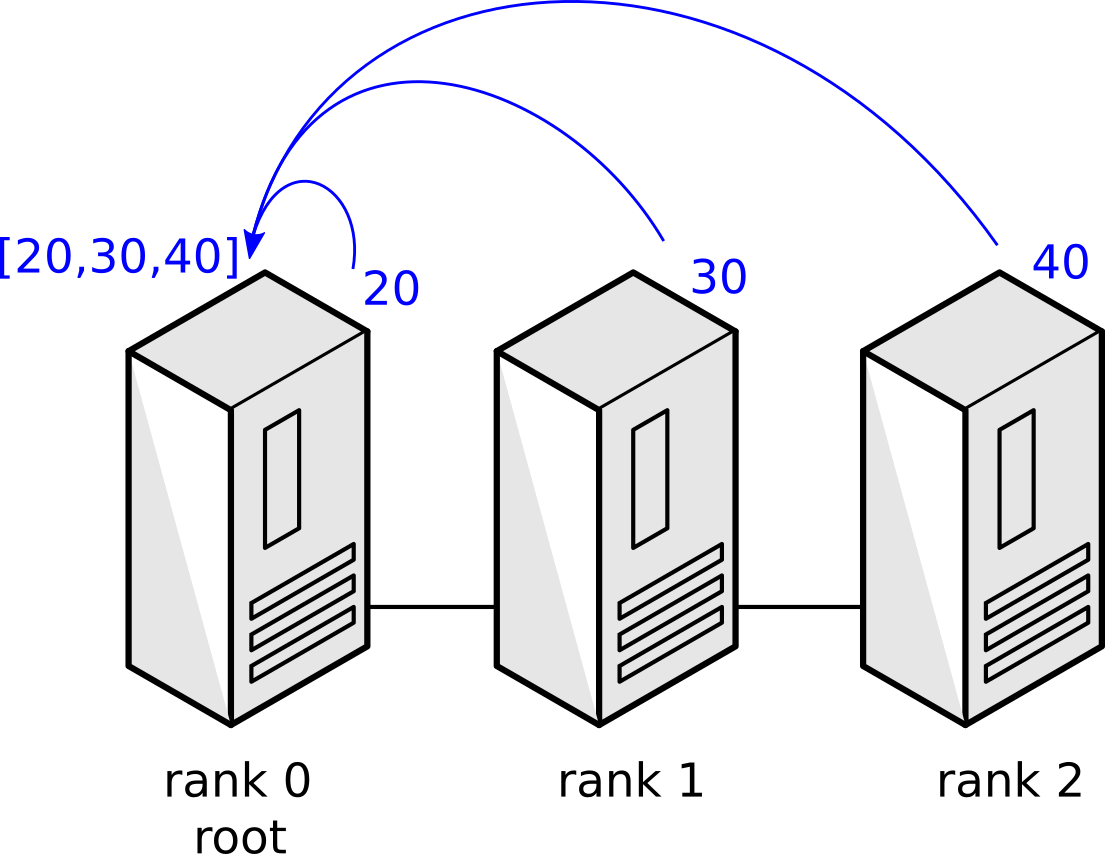
</div>

In [ ]:
code = quote
    using MPI; MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    snd = 10*(rank+2)
    println("I am sending $snd")
    rcv = MPI.Gather(snd,comm;root)
    if rank == root
        println("I have received: $rcv")
    end
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

### Scatter

The root rank contains a buffer (e.g., a vector) of values (one value for each rank in a communicator). Scatter sends one value to each rank (the root rank also receives a value). The root rank can be any process in a communicator.

<div>
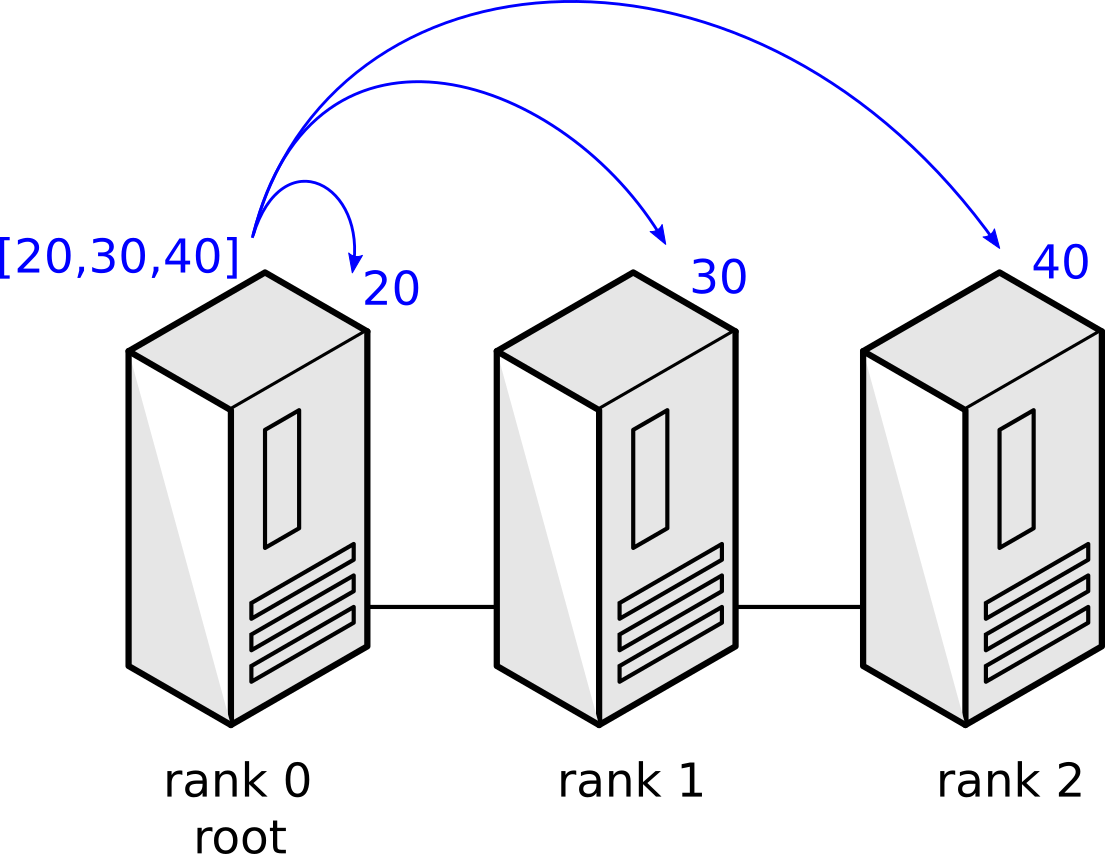
</div>

In [ ]:
code = quote
    using MPI; MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    rcv = Ref(0) 
    if rank == root
        snd = [10*(i+1) for i in 1:nranks]
        println("I am sending: $snd")
    else
        snd = nothing
    end    
    MPI.Scatter!(snd,rcv,comm;root)
    println("I have received: $(rcv[])")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

### Bcast (broadcast)

Similar to scatter, but we send the same message to all processes.

<div>
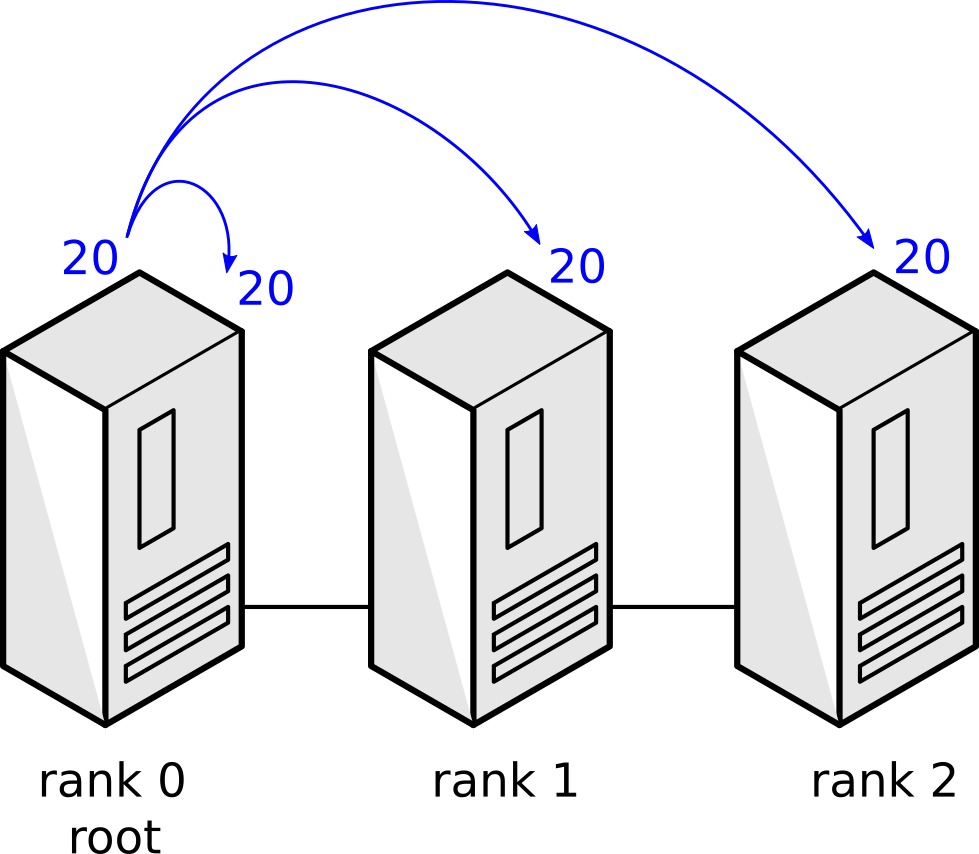
</div>

In [ ]:
code = quote
    using MPI; MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nranks = MPI.Comm_size(comm)
    rank = MPI.Comm_rank(comm)
    root = 0
    buffer = Ref(0)
    if rank == root
        buffer[] = 20
        println("I am sending: $(buffer[])")
    end    
    MPI.Bcast!(buffer,comm;root)
    println("I have received: $(buffer[])")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

### Barrier

In [ ]:
code = quote
    using MPI; MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    sleep(rand(1:3))
    MPI.Barrier(comm)
    println("Done!")
end
run(`$(mpiexec()) -np 3 julia --project=. -e $code`);

## Point-to-Point communication


MPI also provides point-to-point communication directives for arbitrary communication between processes. Point-to-point communications are two-sided: there is a sender and a receiver. Here, we will discuss these basic directives:

- `MPI.Isend`, and `MPI.Irecv!` (*non-blocking directives*)
- `MPI.Send`, and `MPI.Recv!` (*blocking directives*)


Non-blocking directives return immediately and return an `MPI.Request` object. This request object can be queried with functions like `MPI.Wait`. It is mandatory to wait on the request object before reading the receive buffer, or before writing again on the send buffer.

For blocking directives, it is save to read/write from/to the receive/send buffer once the function has returned. By default, blocking directives might wait (or might not wait) for a matching send/receive. 
For fine control,  MPI offers advanced *blocking* directives with different blocking behaviors (called communication modes, see section 3.9 of the MPI standard 4.0). Blocking communication will be discussed later in the course.



### Blocking communication

If we start a receive before a matching send, we will block in the call to `MPI.Recv!`. Run the next cell and note that the message is not printed since the process is blocked at `MPI.Recv!` waiting for a matching send.

In [ ]:
@spawnat 4 begin
    buffer = Ref(0)
    comm = MPI.COMM_WORLD
    MPI.Recv!(buffer,comm;source=2-2,tag=0)
    println("I have received $(buffer[]).")
end;

If you run the next cell containing the corresponding send, the communication will take place.

In [ ]:
@spawnat 2 begin
    buffer = Ref(2)
    comm = MPI.COMM_WORLD
    MPI.Send(buffer,comm;dest=4-2,tag=0)
    println("I have send $(buffer[]). It is now safe to overwite the buffer.")
end;

### MPI does not integrate well with Julia Tasks

MPI blocks without yielding (we cannot switch to other Julia tasks). Run next cell:

In [ ]:
@spawnat 4 begin
    buffer = Ref(0)
    comm = MPI.COMM_WORLD
    MPI.Recv!(buffer,comm;source=2-2,tag=0)
    println("I have received $(buffer[]).")
end;

Now try to spawn other tasks on process 4 by running next cell. This task will not be served yet.

In [ ]:
@spawnat 4 println("Hello!");

We first need to unlock the receive with a matching send. Then the task printing "Hello!" will be finally served.

In [ ]:
@spawnat 2 begin
    buffer = Ref(2)
    comm = MPI.COMM_WORLD
    MPI.Send(buffer,comm;dest=4-2,tag=0)
    println("I have send $(buffer[]). It is now safe to overwite the buffer.")
end;

### Non-blocking communication

In [ ]:
@spawnat 4 begin
    buffer = Ref(0)
    comm = MPI.COMM_WORLD
    req = MPI.Irecv!(buffer,comm;source=2-2,tag=0)
    println("Not yet safe to read the buffer")
    MPI.Wait(req)
    println("I have received $(buffer[]).")
end;

In [ ]:
@spawnat 2 begin
    buffer = Ref(2)
    comm = MPI.COMM_WORLD
    req = MPI.Isend(buffer,comm;dest=4-2,tag=0)
    println("Not yet safe to write the buffer")
    MPI.Wait(req)
    println("I have send $(buffer[]). It is now safe to overwite the buffer.")
end;

### Example

The first rank generates a message and sends it to the last rank. The last rank receives the message and multiplies it by a coefficient. The last rank sends the result back to the first rank.

<div>
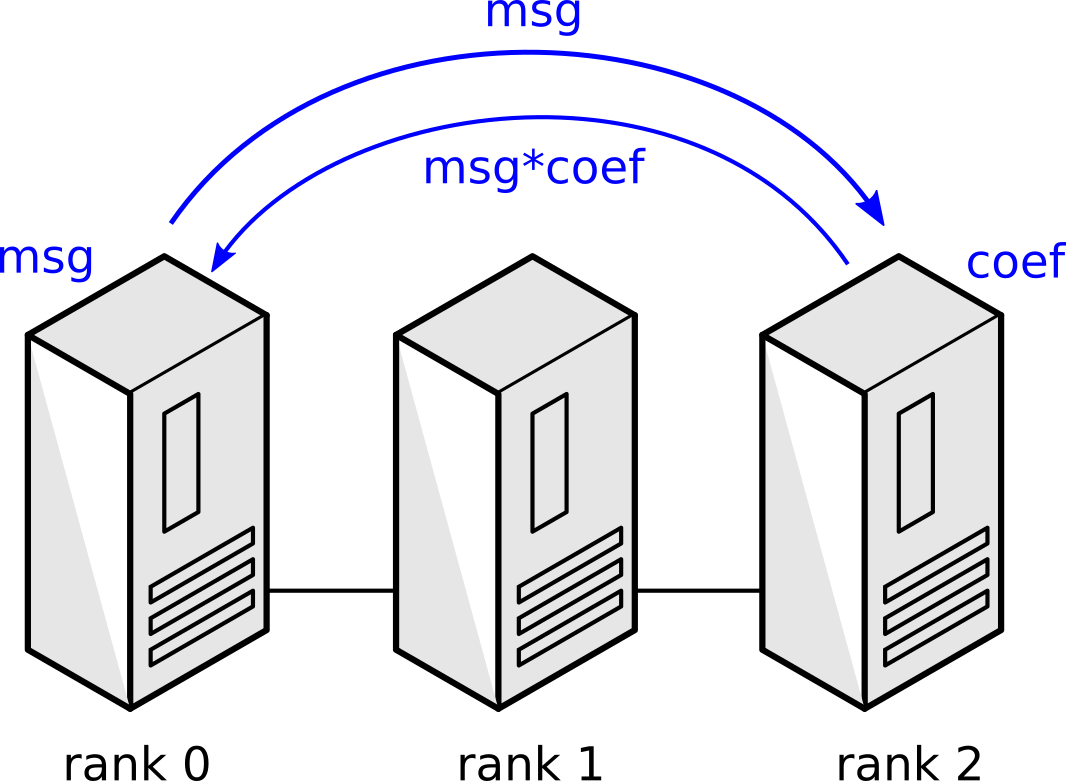
</div>


In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    snder = 0
    rcver = nranks-1
    buffer = Ref(0)
    if rank == snder
        msg = 10*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=rcver,tag=0)
        MPI.Wait(req)
        req = MPI.Irecv!(buffer,comm,source=rcver,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
    end
    if rank == rcver
        req = MPI.Irecv!(buffer,comm,source=snder,tag=0)
        MPI.Wait(req)
        msg = buffer[]
        println("I have received: $msg")
        coef = (rank+2)
        msg = msg*coef
        println("I am sending: $msg")
        buffer[] = msg
        req = MPI.Isend(buffer,comm;dest=snder,tag=0)
        MPI.Wait(req)
    end
end

<div class="alert alert-block alert-warning">
<b>Important:</b> In non-blocking communication, use <code>MPI.Wait()</code> before modifying the send buffer or using the receive buffer.
</div>

### Example (with blocking directives)

In [ ]:
@everywhere workers() begin
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    snder = 0
    rcver = nranks-1
    buffer = Ref(0)
    if rank == snder
        msg = 10*(rank+2)
        println("I am sending: $msg")
        buffer[] = msg
        MPI.Send(buffer,comm;dest=rcver,tag=0)
        MPI.Recv!(buffer,comm,source=rcver,tag=0)
        msg = buffer[]
        println("I have received: $msg")
    end
    if rank == rcver
        MPI.Recv!(buffer,comm,source=snder,tag=0)
        msg = buffer[]
        println("I have received: $msg")
        coef = (rank+2)
        msg = msg*coef
        println("I am sending: $msg")
        buffer[] = msg
        MPI.Send(buffer,comm;dest=snder,tag=0)
    end
end

<div class="alert alert-block alert-warning">
<b>Important:</b> Blocking directives might look simpler to use, but they can lead to dead locks if the sends and receives are not issued in the right order. Non-blocking directives can also lead to dead locks, but when waiting for the request, not when calling the send/receive functions.
</div>

## Exercises

### Exercise 1

Implement this "simple" algorithm (the telephone game):

Rank 0 generates a message (an integer). Rank 0 sends the message to rank 1. Rank 1 receives the message, increments the message by 1, and sends the result to rank 2. Rank 2 receives the message, increments the message by 1, and sends the result to rank 3. Etc. The last rank sends back the message to rank 0 closing the ring. See the next figure. Implement the communications using MPI. Do not use `Distributed`.


<div>
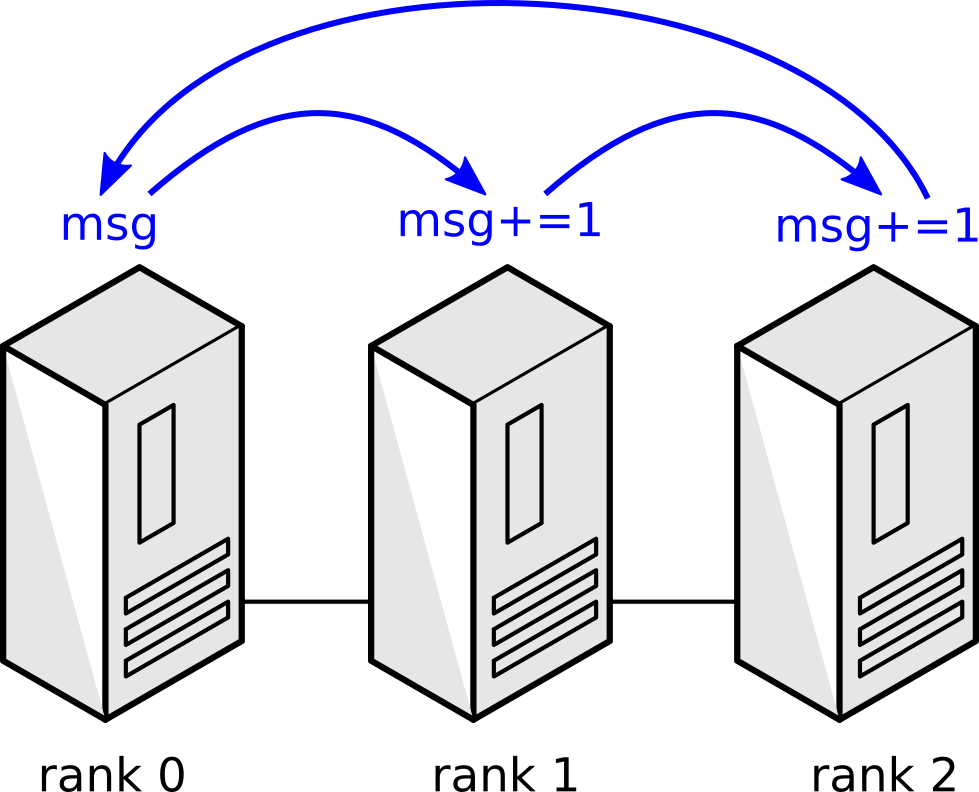
</div>

# License

This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.